# Entanglement-assisted benchmarking

- With parallel CNOT



In [2]:
from datetime import datetime
import numpy as np
import sys, json, copy, time, pickle, random
from concurrent.futures import ThreadPoolExecutor
import qiskit
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit_aer import StatevectorSimulator, AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, amplitude_damping_error, ReadoutError
# from qiskit.providers.ibmq.managed import IBMQJobManager, ManagedJobSet
# from qiskit.providers.ibmq.apiconstants import ApiJobShareLevel
from qiskit.quantum_info.operators.symplectic import pauli
import matplotlib.pyplot as plt
from scipy.stats import sem, unitary_group
from scipy import sparse

# import EAB_submit_2 as EAB_submit
# import EAB_process
from statistics import stdev
import itertools
from qiskit.compiler import transpile

from qiskit.quantum_info import Pauli
from qiskit_ionq import IonQProvider
import os
sys.path.append(r"/Users/yzhu/yzhu_work/gates projects/EAB/EAB_code from Senrui")
import EAB_submit, EAB_process
from qubit_map import my_qubit_maps

## Additional functions

In [3]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

## Data generation

In [5]:

use_density_matrix = False # density matrix based / measurement based simulation
periodic = False # not used


os.environ["IONQ_API_KEY"] = "8CMm5AaUNffwPo9gf4X73klW1sv1tCGM"
my_api_key = os.getenv("IONQ_API_KEY")
provider = IonQProvider(my_api_key)
backend_sim = provider.get_backend("ionq_simulator")
# choose one

use_QPU = True
if use_QPU==True:
    backend = provider.get_backend("ionq_qpu.aria-1")
    # backend = provider.get_backend("ionq_simulator")



# parameters: n, Lrange, C, shots
# use_readout_error = True
shots = 2000
n = 2 # num of qubit
n_total = 2*n
# Lrange = list(range(2,39,4)) # len = 10
Lrange = [2**x for x in range(1,6)]
C = 20
batch = 1
gset = "Pauli"
q = my_qubit_maps['local']
repeat = [1 for k in Lrange] # not used

clifford_layer = 'XX'


print("EAB, ", "n=%d" % n)
print("simulation method:", backend.configuration().description)



data = {}
filename=""
token = ''.join(random.choice([str(j) for j in range(10)]) for i in range(10))
now=datetime.now()
dt_string = now.strftime("%m%d%Y %H:%M:%S")
# print (type(now))
filename = "EAB_XX" + token+dt_string



eab_data, eab_circ_all = EAB_submit.submit_eab(n,n_total,clifford_layer = clifford_layer,Lrange=Lrange,C=C,batch=batch, qubit_map=q,gset=gset,repeat=repeat,periodic=periodic,use_density_matrix=use_density_matrix)
print("created %d circuits" % len(eab_circ_all[0]))
data_batch = eab_data["batch_0"]
print("length of data_batch %d" %len(data_batch))

print(eab_circ_all[0][0]) # print a typical example

#simulate and save simulated results
job_sim = backend_sim.run(eab_circ_all[0], shots=shots) 
result = job_sim.result()
eab_data["result"] = [result.to_dict()]

eab_data["parameters"] = {}
eab_data["parameters"]['n'] = n 
eab_data["parameters"]['n_total'] = n_total
eab_data["parameters"]['shots'] = shots 
eab_data["parameters"]['Lrange'] = Lrange 
eab_data["parameters"]['C'] = C
eab_data["parameters"]['repeat'] = repeat
eab_data['token'] = token
with open('/Users/yzhu/yzhu_work/gates projects/EAB/scripts-make circuits/ionq submission /submit/' + filename, 'wb') as outfile:
    pickle.dump(eab_data, outfile)


#actually run if use_QPU= True
if use_QPU is True:
    job = backend.run(eab_circ_all[0], shots=shots) 
    job_id=job.job_id()
    eab_data["job_set_id"] = job_id
    print(job.job_id())


# result = job.result()
# eab_data["result"] = [result.to_dict()]

# eab_data["parameters"] = {}
# eab_data["parameters"]['n'] = n 
# eab_data["parameters"]['n_total'] = n_total
# eab_data["parameters"]['shots'] = shots 
# eab_data["parameters"]['Lrange'] = Lrange 
# eab_data["parameters"]['C'] = C
# # eab_data["parameters"]['eps_readout'] = eps_readout
# eab_data["parameters"]['repeat'] = repeat

# eab_data['token'] = token

# if use_QPU is true:
#     eab_data["job_set_id"] = job_id

# test: data saving
# print(eab_data)
# print(token)
# open ('submit/' + filename, 'x')
# with open('/Users/yzhu/yzhu_work/gates projects/EAB/scripts-make circuits/ionq submission /submit/' + filename, 'wb') as outfile:
#     pickle.dump(eab_data, outfile)

# print(token)

EAB,  n=2
simulation method: IonQ QPU
created 100 circuits
length of data_batch 100
     ┌───┐           ░ ┌───┐┌───────────┐ ░ ┌───┐┌───────────┐ ░ ┌───┐ ░      »
q_0: ┤ H ├──■────────░─┤ X ├┤0          ├─░─┤ I ├┤0          ├─░─┤ I ├─░───■──»
     ├───┤  │        ░ ├───┤│  Rxx(π/2) │ ░ ├───┤│  Rxx(π/2) │ ░ ├───┤ ░   │  »
q_1: ┤ H ├──┼────■───░─┤ I ├┤1          ├─░─┤ Y ├┤1          ├─░─┤ Z ├─░───┼──»
     └───┘┌─┴─┐  │   ░ └───┘└───────────┘ ░ └───┘└───────────┘ ░ └───┘ ░ ┌─┴─┐»
q_2: ─────┤ X ├──┼───░─────────────────────────────────────────────────░─┤ X ├»
          └───┘┌─┴─┐ ░                                                 ░ └───┘»
q_3: ──────────┤ X ├─░─────────────────────────────────────────────────░──────»
               └───┘ ░                                                 ░      »
c: 4/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌───┐      ░ ┌─┐         
«q_0

/var/folders/6l/f5pw0tyx785dhvmqpb7282h00000gn/T/ipykernel_68569/1922627661.py:57: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.qasm()`` is deprecated as of qiskit 0.46. It will be removed in the 1.0.0 release. Instead use the qiskit.qasm2.dump() or qiskit.qasm2.dumps() function
  print (eab_circ_all[0][0].qasm())


05b77057-878c-4a5f-b993-3636b2b8f727


KeyboardInterrupt: 

In [17]:
job_id="05b77057-878c-4a5f-b993-3636b2b8f727"

# Retrieve the job
job = backend.retrieve_job(job_id)

# Print the job status
print(job.status())


JobStatus.QUEUED


In [10]:
with open( "/Users/yzhu/yzhu_work/gates projects/EAB/scripts-make circuits/ionq submission /submit/EAB_XX918192600509012024 15:53:32", 'rb') as infile:
    eab_data = pickle.load(infile)


## Data analysis

In [14]:
# import EAB_process
'''Use these if read from file'''
# token = "1011327761"
# filename = "sim_eab_cnot_2022oct_" + token
# with open('data/' + filename, 'rb') as infile:
#     eab_data = pickle.load(infile)



n = eab_data["parameters"]['n']
n_total = eab_data["parameters"]['n_total'] 
shots = eab_data["parameters"]['shots'] 
Lrange = eab_data["parameters"]['Lrange']
C = eab_data["parameters"]['C'] 
# eps_readout = eab_data["parameters"]['eps_readout'] 
repeat = eab_data["parameters"]['repeat']

'''Specify a set of Pauli you want to estimate'''
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = n)] #full

# pauli_request_list = ['XX']

eab_result = EAB_process.process_EAB(batch, Lrange, eab_data, pauli_request_list, repeat=repeat, periodic=periodic,use_density_matrix=use_density_matrix)

# fidelity_list[1..512] = [0.99,0.98,...]

raw_fidelity_list = eab_result["fidelity_list"]


# sys.exit(0)

fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*n):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process.fit_EAB(Lrange, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err
# print(fidelity_list)

# print(stdev_list)
print("Parameters: n = %d, C = %d, " % (n,C), "L = ", str(Lrange))

if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

# if use_readout_error is True:
#     print("Measurement bitflip rate = %f" % eps_readout)
# else:
#     print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))



Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
Total error =  0.0
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0 inf
YI 0.0 inf
ZI 0.0 inf
IX 0.0 inf
XX 0.0 inf
YX 0.0 inf
ZX 0.0 inf
IY 0.0 inf
XY 0.0 inf
YY 0.0 inf
ZY 0.0 inf
IZ 0.0 inf
XZ 0.0 inf
YZ 0.0 inf
ZZ 0.0 inf


Note that, the estimation suffers from some degeneracy. E.g., $\lambda_{IZ}$ and $\lambda_{ZZ}$ cannot be individually addressed. Only their geometric mean is estimated and reported. This issue is detailed in [The learnability of Pauli noise](https://arxiv.org/abs/2206.06362).

In [15]:
error_list = fidelity_to_error(fidelity_list,n)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])

Label / Pauli error rates
II 1.0
XI 0.0
YI 0.0
ZI 0.0
IX 0.0
XX 0.0
YX 0.0
ZX 0.0
IY 0.0
XY 0.0
YY 0.0
ZY 0.0
IZ 0.0
XZ 0.0
YZ 0.0
ZZ 0.0


<BarContainer object of 15 artists>

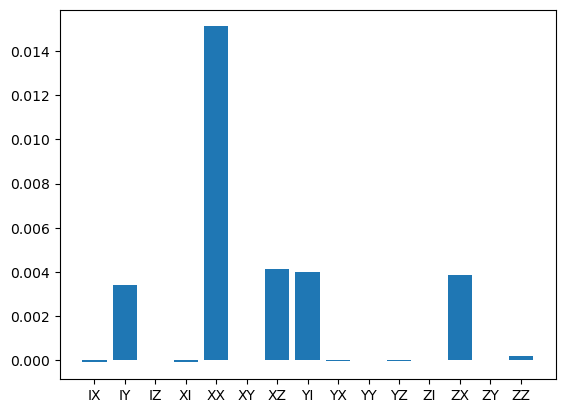

In [6]:
plt.bar([label for label in error_list.keys()][1:],[error_list[label] for label in error_list.keys()][1:])

Similarly, in the estimation $\hat{p}_{XI}=\hat{p}_{XX}=0.0025$ due to degeneracy.

In [7]:
# True value for this specific noise model
def f_true(P):
    ans = 0.0
    for Pi in P:
        if Pi == 'Z' or Pi == 'Y':
            ans += 2*eps
    return ans
def p_true(P):
    if P == "XI" or P == "IX":
        return eps
    else:
        return 0.0

print("Label / True infidelity/ True Pauli error")
for P in pauli_request_list:
    print(P[::-1]," ",f_true(P)," ",p_true(P))

Label / True infidelity/ True Pauli error
II   0.0   0.0
XI   0.0   0.01
YI   0.02   0.0
ZI   0.02   0.0
IX   0.0   0.01
XX   0.0   0.0
YX   0.02   0.0
ZX   0.02   0.0
IY   0.02   0.0
XY   0.02   0.0
YY   0.04   0.0
ZY   0.04   0.0
IZ   0.02   0.0
XZ   0.02   0.0
YZ   0.04   0.0
ZZ   0.04   0.0


In [8]:
plot_dic={}
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], (1-fidelity_list[pauli_label])-f_true(pauli_label))
    plot_dic[pauli_label[::-1]]=(1-fidelity_list[pauli_label])-f_true(pauli_label)

II 0.0
XI 3.3201099060020667e-06
YI -0.0005111871584372145
ZI -0.00033004173029758596
IX -2.4565815118782197e-05
XX -6.963699108464283e-06
YX -0.0005570673255199492
ZX -0.0003608693658354416
IY 0.009727975101719095
XY 0.009694016999577743
YY -0.010444557418704058
ZY -0.010403352430777467
IZ 0.009820235421757268
XZ 0.009793584856456001
YZ -0.010338551447318066
ZZ -0.010319975755474907


In [9]:
print (plot_dic)

{'II': 0.0, 'XI': 3.3201099060020667e-06, 'YI': -0.0005111871584372145, 'ZI': -0.00033004173029758596, 'IX': -2.4565815118782197e-05, 'XX': -6.963699108464283e-06, 'YX': -0.0005570673255199492, 'ZX': -0.0003608693658354416, 'IY': 0.009727975101719095, 'XY': 0.009694016999577743, 'YY': -0.010444557418704058, 'ZY': -0.010403352430777467, 'IZ': 0.009820235421757268, 'XZ': 0.009793584856456001, 'YZ': -0.010338551447318066, 'ZZ': -0.010319975755474907}


In [10]:
# plot_c100={}
# plot_c100=plot_dic

In [11]:
# plot_c30={}
# plot_c30=plot_dic

In [12]:
# plot_c20={}
# plot_c20=plot_dic

In [13]:
# plot_c10={}
# plot_c10=plot_dic

In [14]:
# plot_c5={}
# plot_c5=plot_dic

In [15]:
# plot_c3={}
# plot_c3=plot_dic

In [16]:
plt.figure(figsize=(15,10))
plt.plot(list(plot_c100.keys()),list(plot_c100.values()),"*",markersize=10)
plt.plot(list(plot_c30.keys()),list(plot_c30.values()),"*",markersize=10)
plt.plot(list(plot_c20.keys()),list(plot_c20.values()),"*",markersize=10)
plt.plot(list(plot_c10.keys()),list(plot_c10.values()),"*",markersize=10)
plt.plot(list(plot_c5.keys()),list(plot_c5.values()),"*",markersize=10)
# plt.plot(list(plot_c3.keys()),list(plot_c3.values()),"*",markersize=10)
plt.legend(["C=100","C=30","C=20","C=10","C=5"])
plt.ylabel("f_measure - f_true",fontsize=20)
plt.savefig("eps=0.01 single CNOT EAB.pdf",format="pdf",dpi=500)

NameError: name 'plot_c100' is not defined

<Figure size 1080x720 with 0 Axes>

In [ ]:
print (eab_result)